## Evolutionary Robotics

In this notebook, we will discuss evolutionary robotics and have you implement an evolutionary algorithm to solve one of the tasks in the AI gym, namely the continuous mountain car task. As you will see, an initial implementation of an evolutionary algorithm for solving a robotics task is easily made. However, obtaining good results may - depending on the task - be hard, and understanding the solution may even be harder still.

The figure below shows the typical evolutionary robotics approach. An initial population is randomly generated. Then there is an iterative process of: (1) Evaluating all individuals (genomes) in the population, resulting in a fitness value for each individual, (2) Selecting the individuals that will be allowed to procreate, i.e., form the new generation, and (3) Vary on the genomes of the selected individuals (using cross-over, mutation, etc.). The process typically terminates either after a specified number of generations, or after convergence to an optimal solution. Evaluation involves the conversion of the genome (genotype) to the phenotype (e.g., setting the weights of a neural network to the values in the genome). Then the phenotype is tested out on the task, typically in simulation but in some works also on real robots. In robotics tasks, evaluation is a stochastic process and execution of the task by the robot can take a long time. 

<img src="evolutionary_robotics_process.jpg" width="50%"></img>
*Figure 1:* Depiction of the typical evolutionary robotics approach. Figure from: _Doncieux, S., Bredeche, N., Mouret, J. B., & Eiben, A. E. G. (2015). Evolutionary robotics: what, why, and where to. Frontiers in Robotics and AI, 2, 4._


## MountainCarContinuous-v0

In this notebook, you will apply an evolutionary robotics approach to the continuous mountain car task. In this task, the car needs to reach the flag on the right mountain, while observing its position and velocity, and acting by means of accelerating the car left or right. The car cannot go straight up the mountain, but has to build up momentum to succeed. The fitness function rewards reaching the flag, and punishes the use of control actions (using less energy to reach the hill top is better). Please see the general description of the task <A HREF="https://gym.openai.com/envs/MountainCarContinuous-v0/" TARGET="_blank">here</A> and the details of the task <A HREF="https://github.com/openai/gym/wiki/MountainCarContinuous-v0" TARGET="_blank">here</A>. Most importantly, it has two observations, i.e., the position and velocity along the trajectory, and one control input, i.e., the applied force, which has to be in the interval $[-1, 1]$.

<img src="continuous_mountain_car.png" width="50%"></img>
*Figure 2:* Screenshot of the continuous mountain car task. 


Below you find code to evaluate an agent a single time in the mountain car environment. Please study the code, and note that the method ```act``` should be replaced in the end with a learned controller.

In [1]:
%matplotlib inline

import os
import matplotlib
import run_cart
import gym
import numpy as np

class random_agent(object):
    """Random agent"""

    def act(self, observation, reward, done):
        return [2.0*np.random.rand()-1.0]
    
agent = random_agent()
reward = run_cart.run_cart_continuous(agent, env=run_cart.CMC_original(), graphics=True)
print('Reward = ' + str(reward))

C:\Users\guido\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Reward = -34.55633989197742


## Using a continuous time recurrent neural network as controller

Of course, random control is not going to solve the task. Below, we introduce an agent that uses a continuous time recurrent neural network for control. This network was introduced by Randall Beer and used for one of the first times in the following article: Beer, Randall D. The dynamics of active categorical perception in an evolved model agent. Adaptive Behavior 11.4 (2003): 209-243.

CTRNNs are different from typical artificial neural networks (ANNs) in that they have an activation state $s$ which leads to a 'neural inertia'. Specifically, the activation formula, expressed as a differential equation, is:

\begin{equation}
\tau_i \dot{s_i} = -s_i + I_i + \sum_{j=1}^{N}{w_{j,i} \sigma (g_j(s_j + \theta_j))},
\end{equation}

where $\tau_i$ is the time constant of neuron $i$, $s_i$ its activation state, and $I_i$ its external inputs. $\sigma$ is the activation function, $g_j$ the gain of neuron $j$, and $\theta_j$ its bias. 

Below, we use <A HREF="https://github.com/madvn/CTRNN" TARGET="_blank">this CTRNN package</A>. It makes no explicit difference between types of neurons. So a network of size 10 means essentially a fully connected network of 10 neurons, where each neuron has connections to all other neurons and itself. In the code below, we give external inputs to the first two neurons, setting these inputs to the observations in the continuous mountain car task. We read out the last neuron as the output to be used for the car control. The activation function is $\sigma(s) = \frac{1}{1+e^{-s}}$.

<FONT COLOR="red">Exercise 1.</FONT>
1. Run the network multiple times. What values does it output over the different runs? Why?
2. Suppose that we want to start optimizing the weights and other parameters to have the car achieve the task. The ```act``` function below then has a fundamental problem. Can you spot what the problem is?


In [2]:
from CTRNN import CTRNN
from scipy.sparse import csr_matrix

class CTRNN_agent(object):
    
    """ Continuous Time Recurrent Neural Network agent. """
    
    n_observations = 2;
    n_actions = 1;
    
    def __init__(self, network_size, weights=[], taus = [], gains = [], biases = []):
        self.network_size = network_size;
        if(self.network_size < self.n_observations + self.n_actions):
            self.network_size = self.n_observations + self.n_actions;
        self.cns = CTRNN(self.network_size, step_size=0.1) 
        if(len(weights) > 0):
            # weights must be a matrix size: network_size x network_size
            self.cns.weights = csr_matrix(weights)
        if(len(biases) > 0):
            self.cns.biases = biases
        if(len(taus) > 0):
            self.cns.taus = taus
        if(len(gains) > 0):
            self.gains = gains
    
    def act(self, observation, reward, done):
        external_inputs = np.asarray([0.0]*self.network_size)
        external_inputs[0:self.n_observations] = observation
        self.cns.euler_step(external_inputs)
        return self.cns.outputs[-self.n_actions:]

# set up a CTRNN agent:
n_neurons = 10;
weights = np.zeros([n_neurons, n_neurons])
taus = np.asarray([0.1]*n_neurons)
gains = np.ones([n_neurons,])
biases = np.zeros([n_neurons,])
agent = CTRNN_agent(n_neurons, weights=weights, taus = taus, gains = gains, biases = biases)

# run the agent:
reward = run_cart.run_cart_continuous(agent, env=run_cart.CMC_original(), simulation_seed=0, graphics=False)

# print the reward:
print('Reward = ' + str(reward))

Reward = -24.99999999999965


## The simplest Evolutionary Algorithm for evolving a CTRNN

Below we implement a very simple evolutionary algorithm that optimizes all CTRNN parameters for the mountain car task. 

### Genotype to Phenotype mapping
We start by changing the CTRNN_agent class, so that it can be initialized with a _genome_. An advantage of using metaheuristic search methods such as evolutionary algorithms is that they can optimize any type of parameter. For evolutionary robotics this means that even the body of the robot and its sensory layout can be optimized. For the CTRNN agent it means that the genome does not only represent the weights, but all parameters for the network, including the time constants and activation function gains. In this case, we map the genotype (all numbers in the range $[0,1]$) to the right phenotype in the ```__init__``` function. We also implement an evaluation function. Read the code in the cell below and run it to activate the new definitions.

In [3]:
from matplotlib import pyplot as plt
from CTRNN import CTRNN
from scipy.sparse import csr_matrix
import run_cart
import gym
import numpy as np


# added unpacking of genome:
class CTRNN_agent(object):
    
    """ Continuous Time Recurrent Neural Network agent. """
    
    n_observations = 2;
    n_actions = 1;
    
    def __init__(self, network_size, genome = [], weights=[], taus = [], gains = [], biases = []):
        
        self.network_size = network_size;
        if(self.network_size < self.n_observations + self.n_actions):
            self.network_size = self.n_observations + self.n_actions;
        self.cns = CTRNN(self.network_size, step_size=0.1) 
        
        if(len(genome) == self.network_size*self.network_size+3*self.network_size):
            # Get the network parameters from the genome:
            weight_range = 3
            ind = self.network_size*self.network_size
            w = weight_range * (2.0 * (genome[:ind] - 0.5))
            weights = np.reshape(w, [self.network_size, self.network_size])
            biases = weight_range * (2.0 * (genome[ind:ind+self.network_size] - 0.5))
            ind += self.network_size
            taus = 0.9 * genome[ind:ind+self.network_size] + 0.05
            ind += self.network_size
            gains = 2.0 * (genome[ind:ind+self.network_size]-0.5)
        
        if(len(weights) > 0):
            # weights must be a matrix size: network_size x network_size
            self.cns.weights = csr_matrix(weights)
        if(len(biases) > 0):
            self.cns.biases = biases
        if(len(taus) > 0):
            self.cns.taus = taus
        if(len(gains) > 0):
            self.gains = gains
    
    def act(self, observation, reward, done):
        external_inputs = np.asarray([0.0]*self.network_size)
        external_inputs[0:self.n_observations] = observation
        self.cns.euler_step(external_inputs)
        output = 2.0 * (self.cns.outputs[-self.n_actions:] - 0.5)
        return output

def evaluate(genome, seed = 0, n_episodes = 1, graphics = False):
    # create the phenotype from the genotype:
    agent = CTRNN_agent(n_neurons, genome=genome)
    # run the agent:
    reward = run_cart.run_cart_continuous(agent, env=run_cart.CMC_original(), simulation_seed=seed, n_episodes=n_episodes, graphics=graphics)
    #print('Reward = ' + str(reward))
    return reward


### The evolutionary algorithm
The cell below shows the code for a simple evolutionary algorithm (EA). 

<FONT COLOR="red">Exercise 2.</FONT>
1. How often is the simulator run in the course of the entire evolution?
2. The code includes the statement ```np.random.seed(1)```.  What happens if you run the evolution again? What is the reason to include this in the code?
3. Run the EA for seeds $\{1,2,3, \ldots, 6\}$. How often does the evolution succeed? What can be the reasons for this?
4. The EA bases the new generation only on the best 3 individuals. It is hence very _elitist_. What is the disadvantage of a very elitist EA? And what is the potential advantage? 
5. Change some EA parameters to see if the evolution finds solutions easier.

Generation 0, mean = -70.27485903737718 max = -0.26454638183519125
Generation 1, mean = -15.540346741958365 max = -0.08221159845531148
Generation 2, mean = -10.292688568701852 max = -0.08386237450873266
Generation 3, mean = -5.202833144357431 max = -0.055131383815547316
Generation 4, mean = -14.679394424711033 max = -0.048527046976674176
Generation 5, mean = -11.545510183584806 max = -0.04073043554642437
Generation 6, mean = -11.101562044357438 max = -0.07039825101454966
Generation 7, mean = -9.854024177302007 max = -0.058505084987687445
Generation 8, mean = -6.1349435880198335 max = -0.06483017111618336
Generation 9, mean = -5.023664969367045 max = -0.05262683407744452
Generation 10, mean = -6.8943561380293525 max = -0.05226025386741356
Generation 11, mean = -14.237077671210791 max = -0.033315434808335466
Generation 12, mean = -5.75087543746175 max = -0.03163777167803782
Generation 13, mean = -9.667802916057193 max = -0.04476742536612565
Generation 14, mean = -15.199407381469051 max =

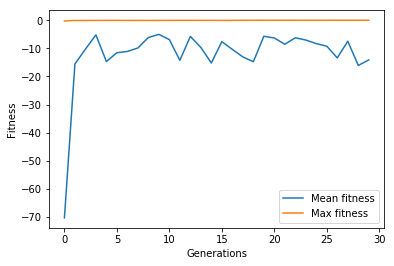

In [4]:
# Parameters CTRNN:
network_size = 10
genome_size = (network_size+3)*network_size

# Evolutionary algorithm:
n_individuals = 30
n_generations = 30
p_mut = 0.05
n_best = 3

np.random.seed(1)
Population = np.random.rand(n_individuals, genome_size)
Reward = np.zeros([n_individuals,])
max_fitness = np.zeros([n_generations,])
mean_fitness = np.zeros([n_generations,])
Best = []
fitness_best = []
for g in range(n_generations):
    
    # evaluate:
    for i in range(n_individuals):
        Reward[i] = evaluate(Population[i, :])
    mean_fitness[g] = np.mean(Reward)
    max_fitness[g] = np.max(Reward)
    print('Generation {}, mean = {} max = {}'.format(g, mean_fitness[g], max_fitness[g]))
    # select:
    inds = np.argsort(Reward)
    inds = inds[-n_best:]
    if(len(Best) == 0 or Reward[-1] > fitness_best):
        Best = Population[inds[-1], :]
        fitness_best = Reward[-1]
    # vary:
    NewPopulation = np.zeros([n_individuals, genome_size])
    for i in range(n_individuals):
        ind = inds[i % n_best]
        NewPopulation[i,:] = Population[ind, :]
        for gene in range(genome_size):
            if(np.random.rand() <= p_mut):
                NewPopulation[i,gene] = np.random.rand()
    Population = NewPopulation

print('Best fitness ' + str(fitness_best))
print('Genome = ')
for gene in range(len(Best)):
    if(gene == 0):
        print('[' + str(Best[gene]) + ', ', end='');
    elif(gene == len(Best)-1):
        print(str(Best[gene]) + ']');
    else:
        print(str(Best[gene]) + ', ', end='');


plt.figure();
plt.plot(range(n_generations), mean_fitness)
plt.plot(range(n_generations), max_fitness)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend(['Mean fitness', 'Max fitness'])

In [5]:
evaluate(Best, graphics=True)

-0.024097384500761806

<FONT COLOR="red">Exercise 3.</FONT>
1. The EA runs evaluate without changing the simulation seed. It may hence be that the successful evolution has overfitted on the initial conditions with seed 0. Change the seed in the first cell below and see if it still works.
2. Run the more extensive evaluation in the second cell below. What is your conclusion?

In [ ]:
evaluate(Best, seed = 646028073333, graphics=True)

In [ ]:
n_tests = 100
fit = np.zeros([n_tests,])
for t in range(n_tests):
    fit[t] = evaluate(Best, seed = 100+t, graphics=False)

plt.figure()
plt.boxplot(fit)
plt.ylabel('Fitness')
plt.xticks([1], ['Fitness best individual'])

### Changing the fitness function
The reward function is a bit _deceptive_. Specifically, agents are rewarded 100 points for achieving the goal, but they are also punished each time step for performing control actions. At the start of learning, when agents do not yet reach the goal, this may lead to the agents learning to stand still. Most learning methods learn best when the progress is rewarded gradually more. When thinking about the search space, the ideal case is a convex function that has a gradient everywhere and only a single maximum. The worst case is a 'needle in a haystack' problem, in which the fitness is 0 everywhere and maximal only at a single point in the search space.

Given the low evolvability of the problem setting above, we now change the reward function. In the cell below, we introduce a class CMC (Continuous Mountain Car) that extends the Continuous_MountainCarEnv class. It reimplements the init, reset and step methods to: (i) keep track of the minimal distance until now to the goal position, and (ii) at each time step add ```1. - self.min_distance / self.max_distance``` to the reward. This should favor individuals early on in evolution that are able to go higher up the slope.

In the evaluate and test_best functions, we add a parameter ```original_reward``` that can switch between the original reward definition and this new one.

Run the cell below to load these new definitions.

In [ ]:
import gym.envs.classic_control as cc
import math

class CMC(cc.Continuous_MountainCarEnv):
    """ Derived class of Continuous Mountain Car, so that we can change, e.g., the reward function.
    """
    # Based on: https://raw.githubusercontent.com/openai/gym/master/gym/envs/classic_control/continuous_mountain_car.py
    
    def __init__(self):
        super(CMC, self).__init__()
        self.max_distance = self.max_position - self.min_position
        self.min_distance = self.max_distance
    
    def reset(self):
        super(CMC, self).reset()
        self.max_distance = self.max_position - self.min_position
        self.min_distance = self.max_distance
        return np.array(self.state)
    
    def step(self, action):

        position = self.state[0]
        velocity = self.state[1]
        force = min(max(action[0], -1.0), 1.0)

        velocity += force*self.power -0.0025 * math.cos(3*position)
        if (velocity > self.max_speed): velocity = self.max_speed
        if (velocity < -self.max_speed): velocity = -self.max_speed
        position += velocity
        if (position > self.max_position): position = self.max_position
        if (position < self.min_position): position = self.min_position
        if (position==self.min_position and velocity<0): velocity = 0

        done = bool(position >= self.goal_position and velocity >= self.goal_velocity)

        # Now you can change the reward function here:
        distance = abs(position - self.goal_position)
        if(distance < self.min_distance):
            self.min_distance = distance
            
        reward = 0
        if done:
            reward = 100.0
        reward -= math.pow(action[0],2)*0.1
        reward += 1. - self.min_distance / self.max_distance

        self.state = np.array([position, velocity])
        return self.state, reward, done, {}
    
    def render(self, mode='human', sleep_time=0.033):
        
        if os.name == 'nt':
            normal_display = True
        else:
            if 'DISPLAY' in os.environ.keys():
                normal_display = True
            else:
                normal_display = False
            
        if normal_display:
            super(CMC_original, self).render()
        else:
            
            # first plot the landscape:
            step = 0.01
            x_coords = np.arange(self.min_position, self.max_position, step)
            y_coords = self._height(x_coords)
            
            if(self.figure_handle == []):
                self.figure_handle = plt.figure('mountain_car')
                self.ax = self.figure_handle.add_subplot(111)
                plt.ion()
                #self.figure_handle.show()
                self.figure_handle.canvas.draw()
            else:
                plt.figure('mountain_car')
            
            self.ax.clear()
            self.ax.plot(x_coords, y_coords)
            self.ax.plot(self.state[0], self._height(self.state[0]), 'ro')
            self.ax.text(self.goal_position, self._height(self.goal_position)+0.02, 'Goal')        
            #        self.figure_handle.canvas.draw()
            #        self.figure_handle.show()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(sleep_time)
    
def evaluate(genome, seed = 0, graphics = False, original_reward=True):
    # create the phenotype from the genotype:
    agent = CTRNN_agent(n_neurons, genome=genome)
    # run the agent:
    if(original_reward):
        reward = run_cart.run_cart_continuous(agent, simulation_seed=seed, graphics=graphics)
    else:
        reward = run_cart.run_cart_continuous(agent, env=CMC(), simulation_seed=seed, graphics=graphics)
    #print('Reward = ' + str(reward))
    return reward

def test_best(Best, original_reward=True):    
    n_tests = 30
    fit = np.zeros([n_tests,])
    for t in range(n_tests):
        fit[t] = evaluate(Best, seed = 100+t, graphics=False, original_reward=True)
    
    plt.figure()
    plt.boxplot(fit)
    plt.ylabel('Fitness')
    plt.xticks([1], ['Fitness best individual'])


<FONT COLOR="red">Exercise 4.</FONT>
1. Run the EA for seeds $\{1,2,3, \ldots, 6\}$. How often does the evolution succeed?

In [ ]:
# Parameters CTRNN:
network_size = 10
genome_size = (network_size+3)*network_size

# Evolutionary algorithm:
n_individuals = 30
n_generations = 30
p_mut = 0.05
n_best = 3

np.random.seed(1) 
original_reward = False
Population = np.random.rand(n_individuals, genome_size)
Reward = np.zeros([n_individuals,])
max_fitness = np.zeros([n_generations,])
mean_fitness = np.zeros([n_generations,])
Best = []
fitness_best = []
for g in range(n_generations):
    
    # evaluate:
    for i in range(n_individuals):
        Reward[i] = evaluate(Population[i, :], original_reward=original_reward)
    mean_fitness[g] = np.mean(Reward)
    max_fitness[g] = np.max(Reward)
    print('Generation {}, mean = {} max = {}'.format(g, mean_fitness[g], max_fitness[g]))
    # select:
    inds = np.argsort(Reward)
    inds = inds[-n_best:]
    if(len(Best) == 0 or Reward[-1] > fitness_best):
        Best = Population[inds[-1], :]
        fitness_best = Reward[-1]
    # vary:
    NewPopulation = np.zeros([n_individuals, genome_size])
    for i in range(n_individuals):
        ind = inds[i % n_best]
        NewPopulation[i,:] = Population[ind, :]
        for gene in range(genome_size):
            if(np.random.rand() <= p_mut):
                NewPopulation[i,gene] = np.random.rand()
    Population = NewPopulation

print('Best fitness ' + str(fitness_best))
print('Genome = ')
for gene in range(len(Best)):
    if(gene == 0):
        print('[' + str(Best[gene]) + ', ', end='');
    elif(gene == len(Best)-1):
        print(str(Best[gene]) + ']');
    else:
        print(str(Best[gene]) + ', ', end='');

plt.figure();
plt.plot(range(n_generations), mean_fitness)
plt.plot(range(n_generations), max_fitness)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend(['Mean fitness', 'Max fitness'])

evaluate(Best, graphics=True)

<FONT COLOR="red">Exercise 5.</FONT>
1. Try out different seeds for a visual evaluation of the performance in the 1st cell below. What do you observe?
2. Run the ```test_best``` function in the 2nd cell below. What do you observe? 
3. What two conclusions can you draw from this concerning the new fitness function?

In [ ]:
evaluate(Best, seed=5, graphics=True)

In [ ]:
test_best(Best, original_reward=True)

## Analyzing the robot's behavior

This notebook has focused on setting up a simple evolutionary algorithm for solving the continuous mountain car task in the AI gym, highlighting some of the challenges in obtaining a successful controller.

When evolution finds a solution to the task, it is often not clear to the designer _how_ the controller has solved the task. Often, evolution finds solutions that exploit the interaction of the robot with the environment. Specifically, evolved controllers exploit sensory-motor coordination, in which the closed loop of motor actions and sensory observations is exploited allowing to solve tasks with less processing. 

Analyzing how an evolved neural controller works is useful for understanding how well the controller will generalize to different instantiations of the task. Also, it gives insight into the nature of intelligence.  

Currently, analysis of the evolved controller is beyond the scope of this notebook. However, we recommend references [2] and [3] for getting ideas on the types of analysis that can be applied.

## References

[1] Doncieux, S., Bredeche, N., Mouret, J. B., & Eiben, A. E. G. (2015). Evolutionary robotics: what, why, and where to. Frontiers in Robotics and AI, 2, 4. <A HREF="https://www.frontiersin.org/articles/10.3389/frobt.2015.00004/full" TARGET="_blank">(open access)</A>

[2] Nolfi, Stefano. Power and the limits of reactive agents. Neurocomputing 42, 1 (2002): 119-145.

[3] Beer, Randall D. The dynamics of active categorical perception in an evolved model agent. Adaptive Behavior 11.4 (2003): 209-243.

## Answers

<FONT COLOR="red">Exercise 1.</FONT>

1. Run the network multiple times. What values does it output over the different runs? Why?

It always outputs ```Reward = -24.99999999999965```. The reason is that the network is always the same and ```simulation_seed``` is always 0. This seed is used for random number generation in the simulation, and the same number will hence always result in the same initial conditions. 

2. Suppose that we want to start optimizing the weights and other parameters to have the car achieve the task. The ```act``` function below then has a fundamental problem. Can you spot what the problem is?

The ```act``` function returns an output of the neural network as the action. The action for the continuous mountain car task can be in the range $[-1,1]$. However, the output of the neurons in the CTRNNs is determined with a sigmoid function: $\sigma(s) = \frac{1}{1+e^{-s}}$, which is in the range $[0,1]$. This means the car would only be able to accelerate to the right.


<FONT COLOR="red">Exercise 2.</FONT>
1. How often is the simulator run in the course of the entire evolution?

The number of simulator runs is: #generations $\times$ #individuals $\times$ #episodes, which is in this case $30 \times 30 \times 1 = 900$.

2. The code includes the statement ```np.random.seed(1)```.  What happens if you run the evolution again? What is the reason to include this in the code?

This random seed determines the initial population and subsequent mutations. So running the evolution again will give the same results. This is useful for reproducibility of the results.

3. Run the EA for seeds $\{1,2,3, \ldots, 6\}$. How often does the evolution succeed? What can be the reasons for this?

The evolution only succeeds for the random seed 6, so once out of 7 times. The current setup has a low _evolvability_. There can be many reasons for the EA failing to find a good solution:
* The EA does not search the search space well enough. 
* The fitness function is not suitable for the way in which the EA searches.
* The genome cannot encode for the solution of the task, i.e., there is no solution in the search space. In this case, since we have at least one successful evolution we can exclude this option, but up until seed 5 this could have been a plausible explanation. A less binary version of this statement is that there are few solutions in the (high-dimensional) search space and the genome is ill-suited for encoding the solution.

4. The EA bases the new generation only on the best 3 individuals. It is hence very _elitist_. What is the disadvantage of a very elitist EA? And what is the potential advantage?  

The disadvantage is that there will be very little genetic diversity in the population. The search can easily get stuck in a local optimum. The potential advantage is that one needs few generations to get a good solution (in this case only 30). Setting the number of selected individuals higher will lead to a slower convergence to a solution, costing more simulation and hence evolution time.

5. Change some EA parameters to see if the evolution finds solutions easier.

This is for the students to try out. Let us know when you find settings that result in substantially better evolvability.

<FONT COLOR="red">Exercise 3.</FONT>
1. The EA runs evaluate without changing the simulation seed. It may hence be that the successful evolution has overfitted on the initial conditions with seed 0. Change the seed in the first cell below and see if it still works.

It still works for most seeds. 

2. Run the more extensive evaluation in the second cell below. What is your conclusion?

The error plot shows a very high performance (~98.1 on average) with little variance. However, looking at the graphical rendering in the previous question shows that the car always starts in similar conditions, despite a changing random seed. 

<FONT COLOR="red">Exercise 4.</FONT>
1. Run the EA for seeds $\{1,2,3, \ldots, 6\}$. How often does the evolution succeed?

Most of the seeds now lead to a successful agent.

<FONT COLOR="red">Exercise 5.</FONT>
1. Try out different seeds for a visual evaluation of the performance in the 1st cell below. What do you observe?

Some of the seeds now do not lead to the car reaching the flag. The agent has a tendency to mostly focus on accelerating to the right.

2. Run the ```test_best``` function in the 2nd cell below. What do you observe? 

The bulk of the results indicates that the car does not reach the flag. Only in a few cases does the car reach the flag. Then still, the original reward is rather low compared with the 98 before.

3. What two conclusions can you draw from this concerning the new fitness function?

We can conclude that (i) the found solution generalizes less well to different initial conditions, and (ii) the new fitness function leads to strategies that use higher control inputs, and hence a lower fitness with the original reward function.

Finding the right fitness / reward function is called _reward shaping_, and it is currently a major problem in both evolutionary robotics and reinforcement learning.